# Version 1.3 5/8/2019

In [42]:
# Dependencies

# Import linear algebra and data manipulation
import numpy as np
import pandas as pd

# Import plotting packages
import matplotlib.pyplot as plt
%matplotlib inline

# Import machine learning for Linear Regression, Random Forest and measuring metrics
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn import metrics
import math

# Deep Learning
from keras.models import Sequential
from keras.layers import Dense
from keras.models import load_model
from keras.utils import to_categorical

# KNN
from sklearn.neighbors import KNeighborsClassifier

# Lasso, Ridge, Elasticnet models
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet

In [2]:
#read the dataset
listings_df = pd.read_csv('./listings.csv')

#find number of listings and number of hosts
listings_number = listings_df['id'].count()
hosts_number = len(listings_df['host_id'].unique())

print('listings.csv dataset contains information on %d listings provided by %d hosts.' % (listings_number, 
                                                                                          hosts_number))

listings.csv dataset contains information on 3723 listings provided by 2732 hosts.


# New Data Cleaning Process

In [3]:
#Helper functions for dataset cleaning
def get_host_since_year(row):
    ''' Get year from a date represented as a string '''
    try:
        host_since = int(row['host_since'].split('-')[0])
    except:
        host_since = np.nan
    return host_since

def get_val_from_list(row, column_name, value):
    ''' Fill in dummy column for values '''
    val = 0.0
    try:
        vals = row[column_name].replace('[', '').replace("'", '').replace("]", '').replace('"', '').replace('{', '').replace('}', '').split(',')
        if value in vals:
            val = 1.0
    except:
        val = 0.0
    return val

def split_list_into_columns(df, column_name, max_dummies_num = 10):
    ''' Split values in columns, which contain lists (for example, amenities) '''
    
    # get dictionary of unique values in lists across dataset rows
    values_dict = {}

    for unique_value in df[column_name].unique(): 
        for value in unique_value.replace('[', '').replace("'", '').replace("]", '').replace('"', '').replace('{', '').replace('}', '').split(','):
            if value in values_dict:
                values_dict[value] = values_dict[value] + 1
            else:
                values_dict[value] = 0
                
    values_sorted = sorted(values_dict.items(), key=lambda kv: kv[1], reverse = True)
      
    # split into columns
    for value in values_sorted[: max_dummies_num]:
        df[column_name + '_' + value[0]] = df.apply(lambda row: get_val_from_list(row, column_name, value[0]),axis=1)
        
    return

def get_extra_people_fee(row):
    ''' Return 1 when the is fee for exatra people '''
    if row['extra_people'] == '$0.00':
        return 0.0
    else:
        return 1.0

#Main dataset cleaning function
def clean_dataset(listings_df):
    '''
    INPUT
    listings_df - pandas dataframe containing listings data 
        
    OUTPUT
    df - cleaned dataset, which contains merged tables:
    1. irrelevant columns are dropped;
    2. string containing dates are converted into numbers;
    3. columns, containing lists, are split into several columns (for example, amenities)
    4. missing values are imputed with mean or mode.
    '''
   
    #drop the irrelevant columns
    columns_to_drop = ['host_id','host_location','host_acceptance_rate','host_neighbourhood',
                   'host_total_listings_count', 'weekly_price', 'monthly_price',
                   'security_deposit', 'cleaning_fee', 'calendar_updated',
                   'listing_url','last_scraped' ,'scrape_id', 'name', 'summary', 'space', 'description',
                   'experiences_offered', 'street', 'neighbourhood', 'neighbourhood_cleansed', 'zipcode',
                   'neighborhood_overview', 'notes', 'transit', 'thumbnail_url', 'medium_url', 'picture_url',
                   'xl_picture_url', 'host_url', 'host_name', 'host_about', 'host_thumbnail_url', 'host_picture_url',
                   'city', 'state', 'market', 'smart_location', 'country_code', 'country', 'latitude', 'longitude',
                   'is_location_exact', 'square_feet', 'has_availability', 'neighbourhood_group_cleansed',
                   'availability_60', 'availability_90', 'availability_365', 'calendar_last_scraped',
                  'first_review', 'last_review', 'requires_license', 'license', 'jurisdiction_names',
                  'reviews_per_month']
    df = listings_df.drop(columns = columns_to_drop) 
     
    #convert price to number
    df['price'] = df['price'].str.replace(r'\$','').str.replace(r'\,','').astype(float)
    
    #convert host_since date into number and fill in missing values, drop the original column
    df['host_since_year'] = df.apply(lambda row: get_host_since_year(row),axis=1)
    df['host_since_year'].fillna(df['host_since_year'].mean(), inplace = True)
    df = df.drop(columns = ['host_since'])
    
    #convert host_response_rate into number and fill in missing values, drop the original column
    df['host_response_rate_num'] = df['host_response_rate'].astype(str)
    df['host_response_rate_num'] = df['host_response_rate_num'].str.replace("%", "").astype("float")
    df['host_response_rate_num'].fillna(df['host_response_rate_num'].mean(), inplace = True)
    
    df['host_response_rate_buckets'] = pd.qcut(df['host_response_rate_num'], 5, labels=False, duplicates = 'drop')
    
    df = df.drop(columns = ['host_response_rate', 'host_response_rate_num'])
    
    #fill missing values with mean value for host_listings_count
    df['host_listings_count'].fillna(df['host_listings_count'].mean(), inplace = True)
    
    #split host_verifications into dummy columns and drop the original column
    split_list_into_columns(df, 'host_verifications')
    df = df.drop(columns = ['host_verifications'])
    
    #fill in missing values for bathrooms, bedrooms and beds with mode
    df['bathrooms'] = df['bathrooms'].fillna(df['bathrooms'].mode()[0])
    df['bedrooms'] = df['bedrooms'].fillna(df['bedrooms'].mode()[0])
    df['beds'] = df['beds'].fillna(df['beds'].mode()[0])
    
    #split amenities into dummy columns and drop the original column
    split_list_into_columns(df, 'amenities')
    df = df.drop(columns = ['amenities'])
    
    #turn extra people fee into binary column (1 - if fee for extra people is charged, 0 - otherwise)
    df['extra_people_fee'] = df.apply(lambda row: get_extra_people_fee(row),axis=1)
    df = df.drop(columns = ['extra_people'])
    
    #fill missing values for review scores columns
    review_scores_columns = ['review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness',
                         'review_scores_checkin', 'review_scores_communication', 'review_scores_location',
                        'review_scores_value']
    for column in review_scores_columns:
        df[column].fillna(df[column].mean(), inplace = True)
    
    return df

In [4]:
# apply functions above to clean dataset
df = clean_dataset(listings_df)

# EDA

In [5]:
df.columns.tolist()

['id',
 'host_response_time',
 'host_is_superhost',
 'host_listings_count',
 'host_has_profile_pic',
 'host_identity_verified',
 'property_type',
 'room_type',
 'accommodates',
 'bathrooms',
 'bedrooms',
 'beds',
 'bed_type',
 'price',
 'guests_included',
 'minimum_nights',
 'maximum_nights',
 'availability_30',
 'number_of_reviews',
 'review_scores_rating',
 'review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_checkin',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_value',
 'instant_bookable',
 'cancellation_policy',
 'require_guest_profile_picture',
 'require_guest_phone_verification',
 'calculated_host_listings_count',
 'host_since_year',
 'host_response_rate_buckets',
 'host_verifications_email',
 'host_verifications_ phone',
 'host_verifications_ reviews',
 'host_verifications_ jumio',
 'host_verifications_ facebook',
 'host_verifications_ kba',
 'host_verifications_ linkedin',
 'host_verifications_ google',
 'host_verifications_phon

In [6]:
#find minimum, maximum and average price for listing
min_price = df['price'].min()
max_price = df['price'].max()
mean_price = df['price'].mean()

print(f'Minimum price per listing is ${min_price}.')
print(f'Maximum price per listing is ${max_price}.')
print(f'Average price per listing is ${mean_price}.')

Minimum price per listing is $10.0.
Maximum price per listing is $2822.0.
Average price per listing is $149.16599516518937.


In [7]:
df = df[df['price'] <= 699]
df['price'].max()


695.0

In [8]:
df = df[df['minimum_nights'] <= 31]
df['minimum_nights'].max()

30

In [9]:
golden_df = df.dropna()
golden_df.shape

(3274, 54)

In [10]:
#creating CSV file of the improved golden version 

golden_df.to_csv('goldenimproved.csv')

# ML Modeling

In [11]:
linear_regression = 0
random_forest = 0

In [12]:
def lr_rf(X, y, TEST_SIZE, RAND_STATE):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RAND_STATE)
    model = LinearRegression()
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    MSE = mean_squared_error(y_test, predictions)
    Error_lr = round(math.sqrt(MSE),2)
    r2 = model.score(X_test, y_test)
    r2a_lr = 1 - (1-model.score(X_test, y_test))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)
    linear_regression = r2a_lr
    print('Linear Regression Results:')
    print(f''' MSE: {MSE}, \n R2: {r2}, \n Radjusted: {r2a_lr} \n Error: {Error_lr} \n \n''')
    print('----------------------------------------')
    regressor = RandomForestRegressor(n_estimators=2000, random_state=RAND_STATE)  
    regressor.fit(X_train, y_train)  
    y_pred = regressor.predict(X_test)  
    print('Random Forest Results:')
    print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
    print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
    print(f'R: {regressor.score(X_test, y_test)}')
    r2a_rf = 1 - (1-regressor.score(X_test, y_test))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)
    random_forest = r2a_rf
    print(f'RAdjusted: {r2a_rf}')
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred))) 

In [13]:
#turn categorical columns into dummies
cat_columns = list(golden_df.select_dtypes(include=['object']).columns)
    
for col in  cat_columns:
    golden_df = pd.concat([golden_df.drop(col, axis=1), pd.get_dummies(golden_df[col], prefix=col, prefix_sep='_',

                                                         drop_first=True, dummy_na=True)], axis=1)


In [14]:
X = golden_df.drop(columns = ['price', 'id'])
y = golden_df["price"]
print(X.shape, y.shape)

(3274, 80) (3274,)


In [15]:
lr_rf(X, y, 0.3, 42)

Linear Regression Results:
 MSE: 2835.1475881994365, 
 R2: 0.6511192328188828, 
 Radjusted: 0.6201763709846374 
 Error: 53.25 
 

----------------------------------------
Random Forest Results:
Mean Absolute Error: 32.632378510762685
Mean Squared Error: 2634.6259800756975
R: 0.6757945381785699
RAdjusted: 0.6470401734937424
Root Mean Squared Error: 51.32860781353511


# Going to split on entire_home

In [16]:
#Viewing info on room_type
df['room_type'].value_counts()

Entire home/apt    2392
Private room       1198
Shared room         101
Name: room_type, dtype: int64

In [17]:
entire_home = df[df['room_type'] == 'Entire home/apt'].copy()

In [18]:
entire_home = entire_home.dropna()
entire_home.shape

(2132, 54)

In [19]:
entire_home = entire_home.drop(columns = 'room_type') 

In [20]:
#turn categorical columns into dummies
cat_columns = list(entire_home.select_dtypes(include=['object']).columns)
    
for col in  cat_columns:
    entire_home = pd.concat([entire_home.drop(col, axis=1), pd.get_dummies(entire_home[col], prefix=col, prefix_sep='_',

                                                         drop_first=True, dummy_na=True)], axis=1)

In [21]:
X_entire = entire_home.drop(columns = ['price', 'id'])
y_entire = entire_home["price"]
print(X_entire.shape, y_entire.shape)

(2132, 74) (2132,)


In [22]:
lr_rf(X_entire, y_entire, 0.3, 42)

Linear Regression Results:
 MSE: 1252697941.687473, 
 R2: -128330.51337867649, 
 Radjusted: -145138.53459995447 
 Error: 35393.47 
 

----------------------------------------
Random Forest Results:
Mean Absolute Error: 40.52947378143266
Mean Squared Error: 3768.4734140810965
R: 0.6139421322071683
RAdjusted: 0.5633788008502311
Root Mean Squared Error: 61.38789305784241


# Strangely Entire Home fails now!

# Deep Learning / Neural Network

In [65]:
# #read the dataset
# deep_data = pd.read_csv('./goldenimproved.csv')

# Create Data
X_dl = golden_df.drop(columns = ['price', 'id'])
y_dl = golden_df["price"]
print(X_dl.shape, y_dl.shape)

(3274, 80) (3274,)


In [66]:
X_train, X_test, y_train, y_test = train_test_split(X_dl, y_dl, random_state=1)

In [67]:
from sklearn.preprocessing import StandardScaler

# Create a StandardScater model and fit it to the training data
X_scaler = StandardScaler().fit(X_train)

In [68]:
# Transform the training and testing data using the X_scaler

X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [70]:
# Create a Neural Network model here
dl_model = Sequential()
dl_model.add(Dense(units=100, activation='relu', input_dim=80))  #fits the shape
dl_model.add(Dense(units=1, activation='linear')) #gives the 0 or 1
#if the computer crashes due to memory go to 50 then 25 then 12 units then layer loss

In [71]:
dl_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 100)               8100      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 101       
Total params: 8,201
Trainable params: 8,201
Non-trainable params: 0
_________________________________________________________________


In [72]:
# Compile the model
dl_model.compile(optimizer='adam',
              loss='mae',
              metrics=['accuracy'])

In [73]:
# Fit the model to the training data
dl_model.fit(
    X_train_scaled,
    y_train,
    epochs=100,
    shuffle=True,
    verbose=2
)

Epoch 1/100
 - 0s - loss: 136.6461 - acc: 0.0000e+00
Epoch 2/100
 - 0s - loss: 129.8748 - acc: 0.0000e+00
Epoch 3/100
 - 0s - loss: 118.7064 - acc: 4.0733e-04
Epoch 4/100
 - 0s - loss: 101.5505 - acc: 0.0012
Epoch 5/100
 - 0s - loss: 80.1439 - acc: 0.0049
Epoch 6/100
 - 0s - loss: 61.3866 - acc: 0.0069
Epoch 7/100
 - 0s - loss: 48.5705 - acc: 0.0098
Epoch 8/100
 - 0s - loss: 42.2790 - acc: 0.0134
Epoch 9/100
 - 0s - loss: 39.5960 - acc: 0.0167
Epoch 10/100
 - 0s - loss: 38.0167 - acc: 0.0171
Epoch 11/100
 - 0s - loss: 36.9051 - acc: 0.0187
Epoch 12/100
 - 0s - loss: 35.9529 - acc: 0.0122
Epoch 13/100
 - 0s - loss: 35.2085 - acc: 0.0208
Epoch 14/100
 - 0s - loss: 34.6064 - acc: 0.0163
Epoch 15/100
 - 0s - loss: 34.1077 - acc: 0.0179
Epoch 16/100
 - 0s - loss: 33.6187 - acc: 0.0257
Epoch 17/100
 - 0s - loss: 33.2425 - acc: 0.0216
Epoch 18/100
 - 0s - loss: 32.8476 - acc: 0.0204
Epoch 19/100
 - 0s - loss: 32.5109 - acc: 0.0236
Epoch 20/100
 - 0s - loss: 32.1871 - acc: 0.0183
Epoch 21/100


In [74]:
deep_model = Sequential()
deep_model.add(Dense(units=100, activation='relu', input_dim=80))
deep_model.add(Dense(units=100, activation='relu'))
deep_model.add(Dense(units=1, activation='linear'))

In [75]:
deep_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 100)               8100      
_________________________________________________________________
dense_11 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 101       
Total params: 18,301
Trainable params: 18,301
Non-trainable params: 0
_________________________________________________________________


In [76]:
deep_model.compile(optimizer='adam',
                   loss='mae',
                   metrics=['accuracy'])

deep_model.fit(
    X_train_scaled,
    y_train,
    epochs=100,
    shuffle=True,
    verbose=2
)

Epoch 1/100
 - 0s - loss: 124.2510 - acc: 0.0000e+00
Epoch 2/100
 - 0s - loss: 57.3340 - acc: 0.0057
Epoch 3/100
 - 0s - loss: 37.3910 - acc: 0.0081
Epoch 4/100
 - 0s - loss: 34.8801 - acc: 0.0138
Epoch 5/100
 - 0s - loss: 33.2641 - acc: 0.0191
Epoch 6/100
 - 0s - loss: 32.4984 - acc: 0.0191
Epoch 7/100
 - 0s - loss: 31.7178 - acc: 0.0200
Epoch 8/100
 - 0s - loss: 31.3220 - acc: 0.0155
Epoch 9/100
 - 0s - loss: 30.9199 - acc: 0.0183
Epoch 10/100
 - 0s - loss: 30.4764 - acc: 0.0220
Epoch 11/100
 - 0s - loss: 30.1111 - acc: 0.0257
Epoch 12/100
 - 0s - loss: 29.9040 - acc: 0.0196
Epoch 13/100
 - 0s - loss: 29.5615 - acc: 0.0179
Epoch 14/100
 - 0s - loss: 29.2464 - acc: 0.0305
Epoch 15/100
 - 0s - loss: 28.9870 - acc: 0.0204
Epoch 16/100
 - 0s - loss: 28.6681 - acc: 0.0318
Epoch 17/100
 - 0s - loss: 28.5273 - acc: 0.0318
Epoch 18/100
 - 0s - loss: 28.2964 - acc: 0.0224
Epoch 19/100
 - 0s - loss: 28.1543 - acc: 0.0289
Epoch 20/100
 - 0s - loss: 27.8333 - acc: 0.0273
Epoch 21/100
 - 0s - los

In [77]:
model_loss, model_accuracy = dl_model.evaluate(
    X_test_scaled, y_test, verbose=2)
print(
    f"Normal Neural Network - Loss: {model_loss}, Accuracy: {model_accuracy}")

Normal Neural Network - Loss: 32.59616068373087, Accuracy: 0.01098901098901099


In [78]:
model_loss, model_accuracy = deep_model.evaluate(
    X_test_scaled, y_test, verbose=2)
print(f"Deep Neural Network - Loss: {model_loss}, Accuracy: {model_accuracy}")

Deep Neural Network - Loss: 34.2709832802797, Accuracy: 0.02442002442002442


In [79]:
# Save the model
dl_model.save("dl_airbnb_trained.h5")
deep_model.save("deep_airbnb_trained.h5")

In [80]:
# Load the model
from keras.models import load_model
dl_airbnb_model = load_model("dl_airbnb_trained.h5")
deep_airbnb_model = load_model("deep_airbnb_trained.h5")

In [ ]:
model_loss, model_accuracy = dl_airbnb_model.evaluate(
    X_test_scaled, y_test, verbose=2)
print(
    f"Normal Neural Network - Loss: {model_loss}, Accuracy: {model_accuracy}")

In [ ]:
model_loss, model_accuracy = deep_airbnb_model.evaluate(
    X_test_scaled, y_test, verbose=2)
print(
    f"Normal Neural Network - Loss: {model_loss}, Accuracy: {model_accuracy}")

# XGBOOST

In [53]:
#train XGBoost model
xgb = xgboost.XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=7)
xgb.fit(X_train,y_train)

#calculate and print scores for the model for top 15 features
y_train_preds = xgb.predict(X_train)
y_test_preds = xgb.predict(X_test)

print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_preds),
        mean_squared_error(y_test, y_test_preds)))
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_preds),
        r2_score(y_test, y_test_preds)))
print('----------------------------------')
MSE = mean_squared_error(y_test, y_test_preds)
Error = round(math.sqrt(MSE),2)
print(Error)
xgboost = r2_score(y_test, y_test_preds)

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


MSE train: 447.657, test: 1741.269
R^2 train: 0.946, test: 0.755
----------------------------------
41.73


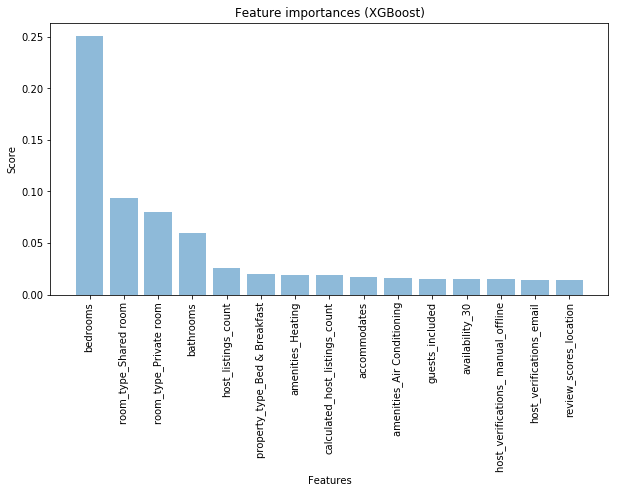

In [54]:
#get feature importances from the model
headers = ["name", "score"]
values = sorted(zip(X_train.columns, xgb.feature_importances_), key=lambda x: x[1] * -1)
xgb_feature_importances = pd.DataFrame(values, columns = headers)

#plot feature importances for top 15 features
features = xgb_feature_importances['name'][:15]
y_pos = np.arange(len(features))
scores = xgb_feature_importances['score'][:15]
 
plt.figure(figsize=(10,5))
plt.bar(y_pos, scores, align='center', alpha=0.5)
plt.xticks(y_pos, features, rotation='vertical')
plt.ylabel('Score')
plt.xlabel('Features')
plt.title('Feature importances (XGBoost)')

plt.savefig('Figures/feature importances XGB.png')
 
plt.show()

# KNN

k: 1, Train/Test Score: 0.997/0.049
k: 3, Train/Test Score: 0.363/0.040
k: 5, Train/Test Score: 0.246/0.045
k: 7, Train/Test Score: 0.207/0.043
k: 9, Train/Test Score: 0.191/0.042
k: 11, Train/Test Score: 0.175/0.046
k: 13, Train/Test Score: 0.160/0.045
k: 15, Train/Test Score: 0.148/0.043
k: 17, Train/Test Score: 0.141/0.043
k: 19, Train/Test Score: 0.132/0.049


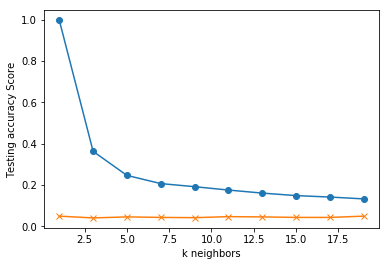

In [41]:
# Loop through different k values to see which has the highest accuracy
# Note: We only use odd numbers because we don't want any ties
train_scores = []
test_scores = []
for k in range(1, 20, 2):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    train_score = knn.score(X_train, y_train)
    test_score = knn.score(X_test, y_test)
    train_scores.append(train_score)
    test_scores.append(test_score)
    print(f"k: {k}, Train/Test Score: {train_score:.3f}/{test_score:.3f}")
    
    
plt.plot(range(1, 20, 2), train_scores, marker='o')
plt.plot(range(1, 20, 2), test_scores, marker="x")
plt.xlabel("k neighbors")
plt.ylabel("Testing accuracy Score")
plt.savefig("Figures/KNN.png")
plt.show()


In [40]:
# Note that k: 8 provides the best accuracy where the classifier starts to stablize
knn = KNeighborsClassifier(n_neighbors=8)
knn.fit(X_train, y_train)
print('k=8 Test Acc: %.3f' % knn.score(X_test, y_test))

k=8 Test Acc: 0.039


# Lasso Model

In [83]:
# Note: Use an alpha of .01 when creating the model for this activity

clf = Lasso(alpha=0.01)
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)
MSE = mean_squared_error(y_test, predictions)
r2 = clf.score(X_test, y_test)
r2a_lasso1 = 1 - (1-clf.score(X_test, y_test))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)
Error_lasso1 = round(math.sqrt(MSE),2)
print(f"MSE: {MSE}, R2: {round(r2,3)}, Radjusted: {round(r2a_lasso1,3)}, Error: {Error_lasso1}")

MSE: 2460.3831348754734, R2: 0.654, Radjusted: 0.616, Error: 49.6


In [84]:
# Note: Use an alpha of .05 when creating the model for this activity

clf = Lasso(alpha=0.05)
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)
MSE = mean_squared_error(y_test, predictions)
r2 = clf.score(X_test, y_test)
r2a_lasso5 = 1 - (1-clf.score(X_test, y_test))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)
Error_lasso5 = round(math.sqrt(MSE),2)
print(f"MSE: {MSE}, R2: {round(r2,3)}, Radjusted: {round(r2a_lasso5,3)}, Error: {Error_lasso5}")

MSE: 2464.6542850885235, R2: 0.653, Radjusted: 0.616, Error: 49.65


# Ridge Model

In [85]:
# Note: Use an alpha of .01 when creating the model for this activity

ridge = Ridge(alpha=.01).fit(X_train, y_train)
predictions = ridge.predict(X_test)
MSE = mean_squared_error(y_test, predictions)
r2 = ridge.score(X_test, y_test)
r2a_ridge1 = 1 - (1-ridge.score(X_test, y_test))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)
Error_ridge1 = round(math.sqrt(MSE),2)
print(f"MSE: {MSE}, R2: {round(r2,3)}, Radjusted: {round(r2a_ridge1,3)}, Error: {Error_ridge1}")

MSE: 2462.143106936749, R2: 0.654, Radjusted: 0.616, Error: 49.62


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number2.169251e-21
  overwrite_a=True).T


In [86]:
# Note: Use an alpha of .05 when creating the model for this activity

ridge = Ridge(alpha=.05).fit(X_train, y_train)
predictions = ridge.predict(X_test)
MSE = mean_squared_error(y_test, predictions)
r2 = ridge.score(X_test, y_test)
r2a_ridge5 = 1 - (1-ridge.score(X_test, y_test))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)
Error_ridge5 = round(math.sqrt(MSE),2)
print(f"MSE: {MSE}, R2: {round(r2,3)}, Radjusted: {round(r2a_ridge5,3)}, Error: {Error_ridge5}")

MSE: 2464.3466213324145, R2: 0.653, Radjusted: 0.616, Error: 49.64


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.084625e-20
  overwrite_a=True).T


# ElasticNet Model

In [87]:
# Note: Use an alpha of .01 when creating the model for this activity

elasticnet = ElasticNet(alpha=.01).fit(X_train, y_train)
predictions = elasticnet.predict(X_test)
MSE = mean_squared_error(y_test, predictions)
r2 = elasticnet.score(X_test, y_test)
r2a_elastic1 = 1 - (1-elasticnet.score(X_test, y_test))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)
Error_elastic1 = round(math.sqrt(MSE),2)
print(f"MSE: {MSE}, R2: {round(r2,3)}, Radjusted: {round(r2a_elastic1,3)}, Error: {Error_elastic1}")

MSE: 2681.104927297282, R2: 0.623, Radjusted: 0.582, Error: 51.78


In [88]:
# Note: Use an alpha of .05 when creating the model for this activity

elasticnet = ElasticNet(alpha=.05).fit(X_train, y_train)
predictions = elasticnet.predict(X_test)
MSE = mean_squared_error(y_test, predictions)
r2 = elasticnet.score(X_test, y_test)
r2a_elastic5 = 1 - (1-elasticnet.score(X_test, y_test))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)
Error_elastic5 = round(math.sqrt(MSE),2)
print(f"MSE: {MSE}, R2: {round(r2,3)}, Radjusted: {round(r2a_elastic5,3)}, Error: {Error_elastic5}")

MSE: 2767.2899207561372, R2: 0.611, Radjusted: 0.568, Error: 52.61


# Reporting Series

In [100]:
compare = pd.Series([linear_regression, random_forest, xgboost, r2a_lasso1, r2a_lasso5, r2a_ridge1, r2a_ridge5, r2a_elastic1, r2a_elastic5], index = ["Linear Regression","Random Forest","XGBBoost", "Lasso Alpha 1", "Lasso Alpha 5", "Ridge Alpha 1", "Ridge Alpha 5", "ElasticNet Alpha 1", "ElasticNet Alpha 5"])
compare

Linear Regression     0.620176
Random Forest         0.647040
XGBBoost              0.754953
Lasso Alpha 1         0.616219
Lasso Alpha 5         0.615553
Ridge Alpha 1         0.615945
Ridge Alpha 5         0.615601
ElasticNet Alpha 1    0.581790
ElasticNet Alpha 5    0.568346
dtype: float64

In [116]:
compare.sort_values(ascending=False)

XGBBoost              0.754953
Random Forest         0.647040
Linear Regression     0.620176
Lasso Alpha 1         0.616219
Ridge Alpha 1         0.615945
Ridge Alpha 5         0.615601
Lasso Alpha 5         0.615553
ElasticNet Alpha 1    0.581790
ElasticNet Alpha 5    0.568346
dtype: float64